### Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

We need to analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Understanding and Defining Churn

There are two main models of payment in the telecom industry - <b>postpaid</b> (customers pay a monthly/annual bill after using the services) and <b>prepaid</b>(customers pay/recharge with a certain amount in advance and then use the services).

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.

This project is based on the Indian and Southeast Asian market.


### Definitions of Churn

This project is based on the usage-based churn which is defined as below :

<b>Usage-based churn</b>: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.


### High-value Churn

In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

In this project, high-value customers based on a below definition : 

Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

<b>Note : It is required to predict churn only on high-value customers.</b>

In [1083]:
# Load libraries
import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline

from scipy.stats import norm
from scipy import stats

import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# `1. EDA`

## `1.1 Loading and Reading Data`

In [1084]:
telecomdata = pd.read_csv("telecom_churn_data.csv")

In [1085]:
telecomdata.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [1086]:
telecomdata.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    mobile_number             99999 non-null  int64  
 1    circle_id                 99999 non-null  int64  
 2    loc_og_t2o_mou            98981 non-null  float64
 3    std_og_t2o_mou            98981 non-null  float64
 4    loc_ic_t2o_mou            98981 non-null  float64
 5    last_date_of_month_6      99999 non-null  object 
 6    last_date_of_month_7      99398 non-null  object 
 7    last_date_of_month_8      98899 non-null  object 
 8    last_date_of_month_9      98340 non-null  object 
 9    arpu_6                    99999 non-null  float64
 10   arpu_7                    99999 non-null  float64
 11   arpu_8                    99999 non-null  float64
 12   arpu_9                    99999 non-null  float64
 13   onnet_mou_6               96062 non-null  fl

In [1087]:
telecomdata.shape

(99999, 226)

In [1088]:
telecomdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [1089]:
telecomdata.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

## `1.2 Finding High-Value Customers`


### From Problem Statement: 

Filter high-value customers

As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

 

After filtering the high-value customers, you should get about 29.9k rows.

#### Calculating the value of the total recharges done for Data / Internet by multiplying `Num of Time data recharged` with the `Average data recharge amount`, for the periods 6 and 7

In [1090]:
telecomdata['total_data_rech_6'] = telecomdata['total_rech_data_6'] * telecomdata['av_rech_amt_data_6']
telecomdata['total_data_rech_7'] = telecomdata['total_rech_data_7'] * telecomdata['av_rech_amt_data_7']
telecomdata.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_6,total_data_rech_7
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,

#### Calculating the value of the total recharges (Recharges + Data) done for periods 6 and 7 and calculating the average of it

In [1091]:
telecomdata['total_amt_data_6'] = telecomdata[['total_rech_amt_6','total_data_rech_6']].sum(axis=1)
telecomdata['total_amt_data_7'] = telecomdata[['total_rech_amt_7','total_data_rech_7']].sum(axis=1)
telecomdata['AVG_amt_data_6_7'] = telecomdata[['total_amt_data_6','total_amt_data_7']].mean(axis=1)
telecomdata.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_6,total_data_rech_7,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,Na

#### Finding the 70th percentile of the average of the amount

In [1092]:
telecomdata[['AVG_amt_data_6_7']].quantile(.70)

AVG_amt_data_6_7    478.0
Name: 0.7, dtype: float64

#### Creating a New Dataset for High Value Customers

In [1093]:
hv_cust = telecomdata[(telecomdata['AVG_amt_data_6_7']> telecomdata['AVG_amt_data_6_7'].quantile(0.7))]
hv_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_6,total_data_rech_7,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,N

**Important:** ***According to the problem statement requirements, High-Value customers are defined as those spending more than or equal to the 70th percentile of the average of periods 6 & 7, which is 478. However, applying the condition `>=` results in over 30k rows, contrary to the specified 29.9k rows in the problem statement. Therefore, the condition is adjusted to only consider values greater than, instead of greater than or equal to.***

In [1094]:
hv_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 231 entries, mobile_number to AVG_amt_data_6_7
dtypes: float64(184), int64(35), object(12)
memory usage: 53.0+ MB


In [1095]:
hv_cust.shape

(29953, 231)

In [1096]:
hv_cust.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_6,total_data_rech_7,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7
count,2.995300e+04,29953.0,29730.0,29730.0,29730.0,29953.000000,29953.000000,29953.000000,29953.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.00000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.000000,29417.000000,28781.000000,28055.000000,29411.0,29417.0,28781.0,28055.0,29411.000000,29417.000000,28781.000000,28055.0000

## `1.3 Tagging Churners`


### From Problem Statement: 

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [1097]:
hv_cust['churn_flag'] = np.where(((hv_cust['total_ic_mou_9'] == 0.00) | (hv_cust['total_og_mou_9'] == 0.00))&((hv_cust['vol_2g_mb_9'] == 0.00) | (hv_cust['vol_3g_mb_9'] == 0.00)),
    1, 0 )
hv_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_6,total_data_rech_7,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,Na

In [1098]:
hv_cust['churn_flag'].value_counts()

0    26698
1     3255
Name: churn_flag, dtype: int64

#### As suggested, dropping the columns that have an extension `"_9"`in them;

In [1099]:
hv_cust = hv_cust.drop(hv_cust.filter(regex='_9', axis = 1).columns, axis=1)
hv_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_6,total_data_rech_7,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,3.58,252.0,252.0,614.0,504.0,559.0,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126

In [1100]:
hv_cust.shape

(29953, 178)

#### After going through the data, we also observed that there is a column with the month names and hence `sep_vbc_3g` is also to be removed;

In [1101]:
hv_cust = hv_cust.drop(hv_cust.filter(regex='sep', axis = 1).columns, axis=1)
hv_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,total_data_rech_7,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,252.0,252.0,614.0,504.0,559.0,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19

In [1102]:
hv_cust.shape

(29953, 177)

In [1103]:
round(hv_cust.isna().mean() * 100,2).sort_values(ascending = False)

arpu_3g_8                   46.80
night_pck_user_8            46.80
date_of_last_rech_data_8    46.80
max_rech_data_8             46.80
count_rech_2g_8             46.80
count_rech_3g_8             46.80
av_rech_amt_data_8          46.80
total_rech_data_8           46.80
fb_user_8                   46.80
arpu_2g_8                   46.80
night_pck_user_6            44.11
total_rech_data_6           44.11
av_rech_amt_data_6          44.11
date_of_last_rech_data_6    44.11
count_rech_3g_6             44.11
arpu_2g_6                   44.11
count_rech_2g_6             44.11
arpu_3g_6                   44.11
total_data_rech_6           44.11
max_rech_data_6             44.11
fb_user_6                   44.11
fb_user_7                   43.12
date_of_last_rech_data_7    43.12
total_rech_data_7           43.12
arpu_2g_7                   43.12
count_rech_2g_7             43.12
count_rech_3g_7             43.12
av_rech_amt_data_7          43.12
total_data_rech_7           43.12
night_pck_user

In [1104]:
unique_counts = hv_cust.nunique().sort_values()
print(unique_counts)

std_ic_t2o_mou_8                1
std_og_t2c_mou_8                1
std_ic_t2o_mou_6                1
std_ic_t2o_mou_7                1
std_og_t2c_mou_7                1
last_date_of_month_8            1
std_og_t2c_mou_6                1
last_date_of_month_6            1
loc_ic_t2o_mou                  1
std_og_t2o_mou                  1
loc_og_t2o_mou                  1
circle_id                       1
last_date_of_month_7            1
fb_user_8                       2
fb_user_6                       2
night_pck_user_8                2
night_pck_user_7                2
night_pck_user_6                2
fb_user_7                       2
churn_flag                      2
monthly_2g_6                    5
monthly_2g_7                    6
monthly_2g_8                    6
monthly_3g_6                   12
monthly_3g_8                   12
monthly_3g_7                   15
count_rech_3g_6                25
sachet_3g_6                    25
sachet_3g_7                    27
count_rech_3g_

In [1105]:
columns_to_remove_single_unique = unique_counts[unique_counts == 1].index
hv_cust_filtered = hv_cust.drop(columns=columns_to_remove_single_unique, inplace=True)

In [1106]:
hv_cust.shape

(29953, 164)

In [1107]:
round(hv_cust.isna().mean() * 100,2).sort_values(ascending = False)

arpu_2g_8                   46.80
count_rech_3g_8             46.80
arpu_3g_8                   46.80
fb_user_8                   46.80
date_of_last_rech_data_8    46.80
total_rech_data_8           46.80
night_pck_user_8            46.80
av_rech_amt_data_8          46.80
max_rech_data_8             46.80
count_rech_2g_8             46.80
total_data_rech_6           44.11
fb_user_6                   44.11
date_of_last_rech_data_6    44.11
max_rech_data_6             44.11
count_rech_2g_6             44.11
count_rech_3g_6             44.11
total_rech_data_6           44.11
arpu_2g_6                   44.11
av_rech_amt_data_6          44.11
arpu_3g_6                   44.11
night_pck_user_6            44.11
count_rech_3g_7             43.12
night_pck_user_7            43.12
total_data_rech_7           43.12
arpu_3g_7                   43.12
date_of_last_rech_data_7    43.12
total_rech_data_7           43.12
fb_user_7                   43.12
arpu_2g_7                   43.12
max_rech_data_

In [1108]:
# Calculate the percentage of missing values for each column
missing_percentages = hv_cust.isna().mean() * 100

# Identify columns with more than 40% missing values
columns_to_drop = missing_percentages[missing_percentages > 40].index

# Drop the identified columns from the DataFrame
hv_cust = hv_cust.drop(columns=columns_to_drop)

In [1109]:
round(hv_cust.isna().mean() * 100,2).sort_values(ascending = False)

loc_ic_mou_8           3.91
loc_og_mou_8           3.91
loc_og_t2c_mou_8       3.91
loc_ic_t2m_mou_8       3.91
loc_og_t2f_mou_8       3.91
loc_ic_t2f_mou_8       3.91
std_og_t2t_mou_8       3.91
loc_og_t2m_mou_8       3.91
std_og_mou_8           3.91
std_ic_t2t_mou_8       3.91
loc_og_t2t_mou_8       3.91
og_others_8            3.91
std_ic_t2m_mou_8       3.91
roam_og_mou_8          3.91
std_ic_t2f_mou_8       3.91
roam_ic_mou_8          3.91
std_og_t2m_mou_8       3.91
std_ic_mou_8           3.91
offnet_mou_8           3.91
spl_og_mou_8           3.91
spl_ic_mou_8           3.91
onnet_mou_8            3.91
isd_og_mou_8           3.91
isd_ic_mou_8           3.91
std_og_t2f_mou_8       3.91
ic_others_8            3.91
loc_ic_t2t_mou_8       3.91
date_of_last_rech_8    1.94
og_others_6            1.81
loc_ic_t2t_mou_6       1.81
std_ic_t2t_mou_6       1.81
loc_ic_t2m_mou_6       1.81
loc_ic_t2f_mou_6       1.81
loc_ic_mou_6           1.81
std_ic_t2m_mou_6       1.81
std_ic_t2f_mou_6    

In [1110]:
hv_cust.shape

(29953, 132)

In [1111]:
# Count the rows having more than 50% missing values
df_missing_rows_50 = hv_cust[(hv_cust.isnull().sum(axis=1)) > (len(hv_cust.columns)//2)]
df_missing_rows_50.shape

(253, 132)

In [1112]:
# Deleting the rows having more than 50% missing values
hv_cust = hv_cust.drop(df_missing_rows_50.index)
hv_cust.shape

(29700, 132)

In [1113]:
round(hv_cust.isna().mean() * 100,2).sort_values(ascending = False)

loc_ic_mou_8           3.09
loc_og_mou_8           3.09
loc_og_t2c_mou_8       3.09
loc_ic_t2m_mou_8       3.09
loc_og_t2f_mou_8       3.09
loc_ic_t2f_mou_8       3.09
std_og_t2t_mou_8       3.09
loc_og_t2m_mou_8       3.09
std_og_mou_8           3.09
std_ic_t2t_mou_8       3.09
loc_og_t2t_mou_8       3.09
og_others_8            3.09
std_ic_t2m_mou_8       3.09
roam_og_mou_8          3.09
std_ic_t2f_mou_8       3.09
roam_ic_mou_8          3.09
std_og_t2m_mou_8       3.09
std_ic_mou_8           3.09
offnet_mou_8           3.09
spl_og_mou_8           3.09
spl_ic_mou_8           3.09
onnet_mou_8            3.09
isd_og_mou_8           3.09
isd_ic_mou_8           3.09
std_og_t2f_mou_8       3.09
ic_others_8            3.09
loc_ic_t2t_mou_8       3.09
date_of_last_rech_8    1.88
og_others_6            0.97
loc_ic_t2t_mou_6       0.97
std_ic_t2t_mou_6       0.97
loc_ic_t2m_mou_6       0.97
loc_ic_t2f_mou_6       0.97
loc_ic_mou_6           0.97
std_ic_t2m_mou_6       0.97
std_ic_t2f_mou_6    

In [1114]:
round(100*(hv_cust['churn_flag'].mean()),2)

10.39

In [1115]:
hv_cust['mobile_number'] = hv_cust['mobile_number'].astype(object)
hv_cust['churn_flag'] = hv_cust['churn_flag'].astype(object)

In [1116]:
hv_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29700 entries, 0 to 99997
Columns: 132 entries, mobile_number to churn_flag
dtypes: float64(102), int64(25), object(5)
memory usage: 30.1+ MB


In [1117]:
# List only the numeric columns
numeric_cols = hv_cust.select_dtypes(exclude=['object']).columns
print(numeric_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'total_amt_data_6', 'total_amt_data_7',
       'AVG_amt_data_6_7'],
      dtype='object', length=127)


In [1118]:
# Removing outliers below 10th and above 90th percentile
for col in numeric_cols: 
    q1 = hv_cust[col].quantile(0.10)
    q3 = hv_cust[col].quantile(0.90)
    iqr = q3-q1
    range_low  = q1-1.5*iqr
    range_high = q3+1.5*iqr
    # Assigning the filtered dataset into data
    data = hv_cust.loc[(hv_cust[col] > range_low) & (hv_cust[col] < range_high)]

data.shape

(29060, 132)

In [1119]:
data.shape

(29060, 132)

## `1.4 Derive new features`


In [1120]:
# List the columns of total mou, rech_num and rech_amt
[total for total in data.columns.to_list() if 'total' in total]

['total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_amt_data_6',
 'total_amt_data_7']

#### Deriving new column `decrease_mou_action`
This column indicates whether the minutes of usage of the customer has decreased in the action phase than the good phase.

In [1121]:
# Total mou at good phase incoming and outgoing
data['total_mou_good'] = (data['total_og_mou_6'] + data['total_ic_mou_6'])

In [1122]:
# Avg. mou at action phase
# We are taking average because there are two months(7 and 8) in action phase
data['avg_mou_action'] = (data['total_og_mou_7'] + data['total_og_mou_8'] + data['total_ic_mou_7'] + data['total_ic_mou_8'])/2

In [1123]:
# Difference avg_mou_good and avg_mou_action
data['diff_mou'] = data['avg_mou_action'] - data['total_mou_good']

In [1124]:
# Checking whether the mou has decreased in action phase
data['decrease_mou_action'] = np.where((data['diff_mou'] < 0), 1, 0)

In [1125]:
data.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag,total_mou_good,avg_mou_action,diff_mou,decrease_mou_action
0,7000842753,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,614.0,504.0,559.0,1,0.00,2.720,2.720,0
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1580.0,790.0,1185.0,1,1113.99,973.090,-140.900,1
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.0,0.0,10.23,0.0,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,9

#### Deriving new column `decrease_rech_num_action`
This column indicates whether the number of recharge of the customer has decreased in the action phase than the good phase.

In [1126]:
# Avg rech number at action phase
data['avg_rech_num_action'] = (data['total_rech_num_7'] + data['total_rech_num_8'])/2

In [1127]:
# Difference total_rech_num_6 and avg_rech_action
data['diff_rech_num'] = data['avg_rech_num_action'] - data['total_rech_num_6']

In [1128]:
# Checking if rech_num has decreased in action phase
data['decrease_rech_num_action'] = np.where((data['diff_rech_num'] < 0), 1, 0)

In [1129]:
data.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag,total_mou_good,avg_mou_action,diff_mou,decrease_mou_action,avg_rech_num_action,diff_rech_num,decrease_rech_num_action
0,7000842753,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,614.0,504.0,559.0,1,0.00,2.720,2.720,0,2.5,-1.5,1
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1580.0,790.0,1185.0,1,1113.99,973.090,-140.900,1,6.0,1.0,0
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.0,0.0,10.23,0.0,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/201

#### Deriving new column `decrease_rech_amt_action`
This column indicates whether the amount of recharge of the customer has decreased in the action phase than the good phase.

In [1130]:
# Avg rech_amt in action phase
data['avg_rech_amt_action'] = (data['total_rech_amt_7'] + data['total_rech_amt_8'])/2

In [1131]:
# Difference of action phase rech amt and good phase rech amt
data['diff_rech_amt'] = data['avg_rech_amt_action'] - data['total_rech_amt_6']

In [1132]:
# Checking if rech_amt has decreased in action phase
data['decrease_rech_amt_action'] = np.where((data['diff_rech_amt'] < 0), 1, 0) 

In [1133]:
data.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag,total_mou_good,avg_mou_action,diff_mou,decrease_mou_action,avg_rech_num_action,diff_rech_num,decrease_rech_num_action,avg_rech_amt_action,diff_rech_amt,decrease_rech_amt_action
0,7000842753,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,614.0,504.0,559.0,1,0.00,2.720,2.720,0,2.5,-1.5,1,252.0,-110.0,1
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1580.0,790.0,1185.0,1,1113.99,973.090,-140.900,1,6.0,1.0,0,2214.0,634.0,0
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.0,0.0,10.23,0.0,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,

#### Deriving new column `decrease_arpu_action`
This column indicates whether the average revenue per customer has decreased in the action phase than the good phase.

In [1134]:
# ARUP in action phase
data['avg_arpu_action'] = (data['arpu_7'] + data['arpu_8'])/2

In [1135]:
# Difference of good and action phase ARPU
data['diff_arpu'] = data['avg_arpu_action'] - data['arpu_6']

In [1136]:
# Checking whether the arpu has decreased on the action month
data['decrease_arpu_action'] = np.where(data['diff_arpu'] < 0, 1, 0)

In [1137]:
data.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag,total_mou_good,avg_mou_action,diff_mou,decrease_mou_action,avg_rech_num_action,diff_rech_num,decrease_rech_num_action,avg_rech_amt_action,diff_rech_amt,decrease_rech_amt_action,avg_arpu_action,diff_arpu,decrease_arpu_action
0,7000842753,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,614.0,504.0,559.0,1,0.00,2.720,2.720,0,2.5,-1.5,1,252.0,-110.0,1,214.3095,16.9245,0
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1580.0,790.0,1185.0,1,1113.99,973.090,-140.900,1,6.0,1.0,0,2214.0,634.0,0,2260.6650,1191.4850,0
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.0,0.0,10.23,0.0,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0

#### Deriving new column `decrease_vbc_action`
This column indicates whether the volume based cost of the customer has decreased in the action phase than the good phase.

In [1138]:
# VBC in action phase
data['avg_vbc_3g_action'] = (data['jul_vbc_3g'] + data['aug_vbc_3g'])/2

In [1139]:
# Difference of good and action phase VBC
data['diff_vbc'] = data['avg_vbc_3g_action'] - data['jun_vbc_3g']

In [1140]:
# Checking whether the VBC has decreased on the action month
data['decrease_vbc_action'] = np.where(data['diff_vbc'] < 0 , 1, 0)

In [1141]:
data.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag,total_mou_good,avg_mou_action,diff_mou,decrease_mou_action,avg_rech_num_action,diff_rech_num,decrease_rech_num_action,avg_rech_amt_action,diff_rech_amt,decrease_rech_amt_action,avg_arpu_action,diff_arpu,decrease_arpu_action,avg_vbc_3g_action,diff_vbc,decrease_vbc_action
0,7000842753,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,614.0,504.0,559.0,1,0.00,2.720,2.720,0,2.5,-1.5,1,252.0,-110.0,1,214.3095,16.9245,0,15.200,-86.000,1
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1580.0,790.0,1185.0,1,1113.99,973.090,-140.900,1,6.0,1.0,0,2214.0,634.0,0,2260.6650,1191.4850,0,38.560,19.820,0
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.0,0.0,10.23,0.0,0.0,0.0,508.36,431.66,

In [1142]:
for col in ['decrease_mou_action', 'decrease_rech_num_action', 'decrease_rech_amt_action', 'decrease_arpu_action', 'decrease_vbc_action']:
    unique_values = data[col].unique()
    percentage_of_ones = data[col].mean() * 100

    print(f"Column: {col}")
    print(f"Unique Values: {unique_values}")
    print(f"Percentage of Ones: {percentage_of_ones:.2f}%\n")


Column: decrease_mou_action
Unique Values: [0 1]
Percentage of Ones: 51.22%

Column: decrease_rech_num_action
Unique Values: [1 0]
Percentage of Ones: 56.87%

Column: decrease_rech_amt_action
Unique Values: [1 0]
Percentage of Ones: 53.18%

Column: decrease_arpu_action
Unique Values: [0 1]
Percentage of Ones: 52.65%

Column: decrease_vbc_action
Unique Values: [1 0]
Percentage of Ones: 16.78%



## `1.5 Univariate Analysis`

In [1143]:
# Converting churn column to int in order to do aggfunc in the pivot table
data['churn_flag'] = data['churn_flag'].astype('int64')

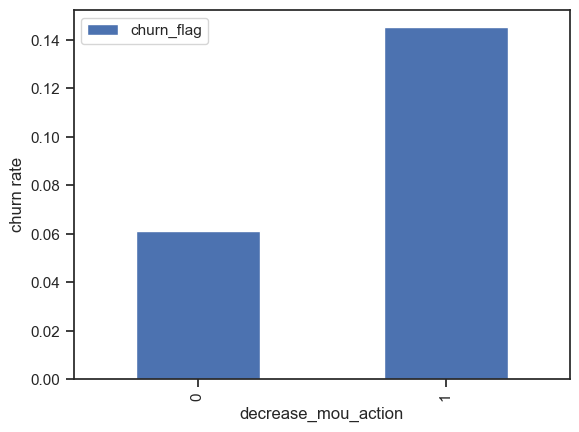

In [1144]:
data.pivot_table(values='churn_flag', index='decrease_mou_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

***Analysis***

We can see that the churn rate is more for the customers, whose minutes of usage(mou) decreased in the action phase than the good phase. 

##### Churn rate on the basis whether the customer decreased her/his number of recharge in action month

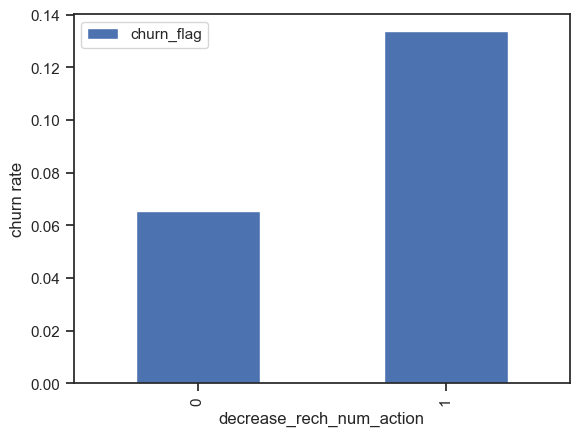

In [1145]:
data.pivot_table(values='churn_flag', index='decrease_rech_num_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

***Analysis***

As expected, the churn rate is more for the customers, whose number of recharge in the action phase is lesser than the number in good phase.

##### Churn rate on the basis whether the customer decreased her/his amount of recharge in action month

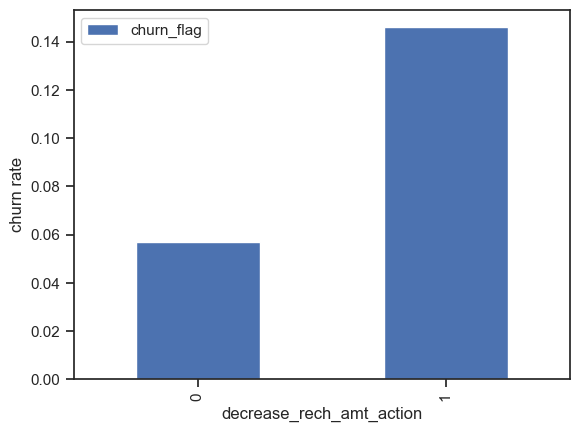

In [1146]:
data.pivot_table(values='churn_flag', index='decrease_rech_amt_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

***Analysis***

Here also we see the same behaviour. The churn rate is more for the customers, whose amount of recharge in the action phase is lesser than the amount in good phase.

##### Churn rate on the basis whether the customer decreased her/his volume based cost in action month

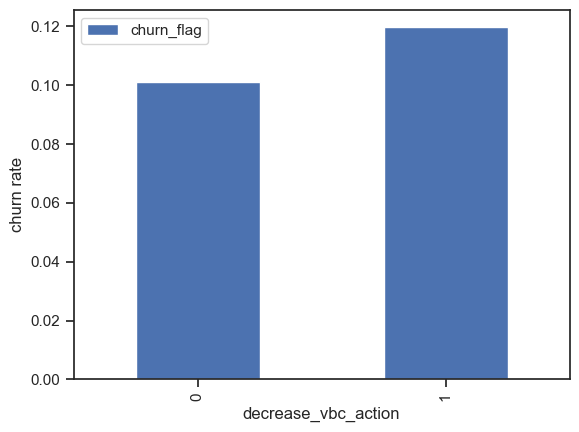

In [1147]:
data.pivot_table(values='churn_flag', index='decrease_vbc_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

***Analysis***

Here we see the expected result. The churn rate is more for the customers, whose volume based cost in action month is increased. That means the customers do not do the monthly recharge more when they are in the action phase.

##### Analysis of the average revenue per customer (churn and not churn) in the action phase

In [1148]:
# Creating churn dataframe
data_churn = data[data['churn_flag'] == 1]
# Creating not churn dataframe
data_non_churn = data[data['churn_flag'] == 0]

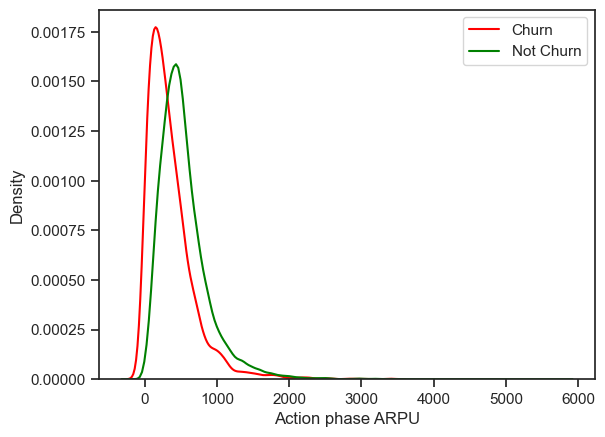

In [1149]:
ax = sns.distplot(data_churn['avg_arpu_action'], label='Churn', hist=False, color='red')
ax = sns.distplot(data_non_churn['avg_arpu_action'], label='Not Churn', hist=False, color='green')
ax.set(xlabel='Action phase ARPU')

# Add legend
ax.legend()

plt.show()

Average revenue per user (ARPU) for the churned customers is mostly densed on the 0 to 900. The higher ARPU customers are less likely to be churned.

ARPU for the not churned customers is mostly densed on the 0 to 1000. 

##### Analysis of the minutes of usage MOU (churn and not churn) in the action phase

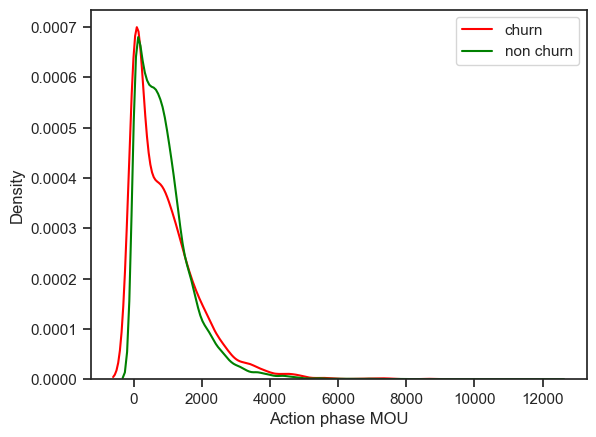

In [1150]:
# Distribution plot
ax = sns.distplot(data_churn['total_mou_good'],label='churn',color='red',hist=False)
ax = sns.distplot(data_non_churn['total_mou_good'],label='non churn',color='green',hist=False)
ax.set(xlabel='Action phase MOU')

# Add legend
ax.legend()

plt.show()

Minutes of usage(MOU) of the churn customers is mostly populated on the 0 to 2500 range. Higher the MOU, lesser the churn probability.

## `1.5 Bivariate Analysis`

##### Analysis of churn rate by the decreasing recharge amount and number of recharge in the action phase

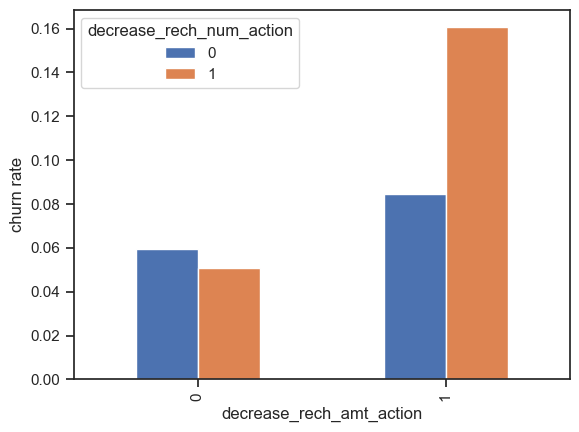

In [1151]:
data.pivot_table(values='churn_flag', index='decrease_rech_amt_action', columns='decrease_rech_num_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

***Analysis***

We can see from the above plot, that the churn rate is more for the customers, whose recharge amount as well as number of recharge have decreased in the action phase than the good phase.

##### Analysis of churn rate by the decreasing recharge amount and volume based cost in the action phase

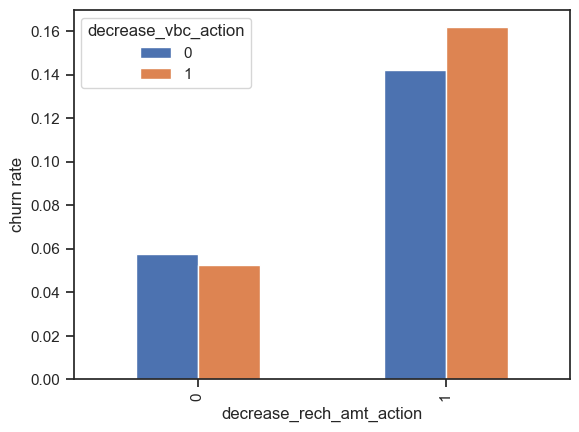

In [1152]:
data.pivot_table(values='churn_flag', index='decrease_rech_amt_action', columns='decrease_vbc_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

***Analysis***

Here, also we can see that the churn rate is more for the customers, whose recharge amount is decreased along with the volume based cost is increased in the action month.

In [1153]:
data = data.drop(['total_mou_good','avg_mou_action','diff_mou','avg_rech_num_action','diff_rech_num','avg_rech_amt_action',
                 'diff_rech_amt','avg_arpu_action','diff_arpu','avg_vbc_3g_action','diff_vbc'], axis=1)

##### Deleting the `date columns` as the date columns are not required in our analysis

In [1154]:
# List the date columns
date_cols = [k for k in data.columns.to_list() if 'date' in k]
print(date_cols) 

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


In [1155]:
# Dropping date columns
data = data.drop(date_cols, axis=1)

In [1156]:
round(data.isna().mean() * 100,2).sort_values(ascending = False)

loc_ic_mou_8                3.10
loc_og_t2t_mou_8            3.10
isd_og_mou_8                3.10
std_og_t2m_mou_8            3.10
spl_og_mou_8                3.10
std_og_t2t_mou_8            3.10
og_others_8                 3.10
loc_og_mou_8                3.10
loc_ic_t2t_mou_8            3.10
loc_og_t2c_mou_8            3.10
loc_ic_t2m_mou_8            3.10
loc_og_t2f_mou_8            3.10
loc_ic_t2f_mou_8            3.10
loc_og_t2m_mou_8            3.10
std_og_mou_8                3.10
std_ic_t2t_mou_8            3.10
std_og_t2f_mou_8            3.10
onnet_mou_8                 3.10
roam_og_mou_8               3.10
std_ic_t2f_mou_8            3.10
ic_others_8                 3.10
roam_ic_mou_8               3.10
isd_ic_mou_8                3.10
std_ic_mou_8                3.10
offnet_mou_8                3.10
std_ic_t2m_mou_8            3.10
spl_ic_mou_8                3.10
std_ic_t2m_mou_6            0.98
isd_og_mou_6                0.98
ic_others_6                 0.98
og_others_

##### Deleting the additional rows with some null values, as they are less than `5%` of whole data

In [1157]:
data_missing_columns = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
data_missing_columns

,null
loc_ic_mou_8,3.10
loc_og_t2t_mou_8,3.10
isd_og_mou_8,3.10
std_og_t2m_mou_8,3.10
spl_og_mou_8,3.10
std_og_t2t_mou_8,3.10
og_others_8,3.10
loc_og_mou_8,3.10
loc_ic_t2t_mou_8,3.10
loc_og_t2c_mou_8,3.10


In [1158]:
datamissing1 = ((data_missing_columns[data_missing_columns['null'] == 3.10]).index).to_list()
datamissing1

['loc_ic_mou_8',
 'loc_og_t2t_mou_8',
 'isd_og_mou_8',
 'std_og_t2m_mou_8',
 'spl_og_mou_8',
 'std_og_t2t_mou_8',
 'og_others_8',
 'loc_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_og_t2c_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_og_t2f_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_og_t2m_mou_8',
 'std_og_mou_8',
 'std_ic_t2t_mou_8',
 'std_og_t2f_mou_8',
 'onnet_mou_8',
 'roam_og_mou_8',
 'std_ic_t2f_mou_8',
 'ic_others_8',
 'roam_ic_mou_8',
 'isd_ic_mou_8',
 'std_ic_mou_8',
 'offnet_mou_8',
 'std_ic_t2m_mou_8',
 'spl_ic_mou_8']

In [1159]:
data_to_delete1 = data[data['loc_ic_mou_8'].isnull() & 
                      data['loc_og_t2t_mou_8'].isnull() & 
                      data['isd_og_mou_8'].isnull() & 
                      data['std_og_t2m_mou_8'].isnull() & 
                      data['spl_og_mou_8'].isnull() & 
                      data['std_og_t2t_mou_8'].isnull() & 
                      data['og_others_8'].isnull() & 
                      data['loc_og_mou_8'].isnull() & 
                      data['loc_ic_t2t_mou_8'].isnull() & 
                      data['loc_og_t2c_mou_8'].isnull() & 
                      data['loc_ic_t2m_mou_8'].isnull() & 
                      data['loc_og_t2f_mou_8'].isnull() & 
                      data['loc_ic_t2f_mou_8'].isnull() & 
                      data['loc_og_t2m_mou_8'].isnull() & 
                      data['std_og_mou_8'].isnull() & 
                      data['std_ic_t2t_mou_8'].isnull() & 
                      data['std_og_t2f_mou_8'].isnull() & 
                      data['onnet_mou_8'].isnull() & 
                      data['roam_og_mou_8'].isnull() & 
                      data['std_ic_t2f_mou_8'].isnull() & 
                      data['ic_others_8'].isnull() & 
                      data['roam_ic_mou_8'].isnull() & 
                      data['isd_ic_mou_8'].isnull() & 
                      data['std_ic_mou_8'].isnull() & 
                      data['offnet_mou_8'].isnull() & 
                      data['std_ic_t2m_mou_8'].isnull() & 
                      data['spl_ic_mou_8'].isnull()]
data_to_delete1.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag,decrease_mou_action,decrease_rech_num_action,decrease_rech_amt_action,decrease_arpu_action,decrease_vbc_action
111,7001300706,596.301,146.073,0.00,55.19,3.26,NaN,45.51,12.34,NaN,0.00,0.0,NaN,0.00,0.0,NaN,55.19,3.26,NaN,43.83,12.34,NaN,0.00,0.00,NaN,0.0,0.0,NaN,99.03,15.61,NaN,0.00,0.00,NaN,0.00,0.00,NaN,1.30,0.0,NaN,1.30,0.00,NaN,0.0,0.0,NaN,0.38,2.71,NaN,1.29,0.0,NaN,102.01,18.33,0.0,50.01,16.66,NaN,160.68,58.53,NaN,5.06,0.40,NaN,215.76,75.59,NaN,0.00,0.00,NaN,0.00,0.00,NaN,1.13,0.0,NaN,1.13,0.00,NaN,217.04,75.59,0.0,0.0,0.0,NaN,0.00,0.0,NaN,0.15,0.0,NaN,12,8,5,704,178,0,154,50,0,154,30,0,284.50,0.00,0.0,0.00,0.00,0.0,1,0,0,0,0,0,0,0,0,1,0,0,332,0.00,0.00,0.00,1110.0,178.0,644.0,1,1,1,1,1,0
188,7000340381,734.641,183.668,0.00,4.38,0.98,NaN,105.16,39.39,NaN,0.00,0.0,NaN,0.00,0.0,NaN,4.38,0.98,NaN,99.81,38.98,NaN,5.34,0.41,NaN,0.0,0.0,NaN,109.54,40.38,NaN,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.0,NaN,0.00,0.00,NaN,0.0,0.0,NaN,0.00,0.00,NaN,0.00,0.0,NaN,109.54,40.38,0.0,21.18,13.44,NaN,217.03,56.63,NaN,18.28,2.94,NaN,256.49,73.03,NaN,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.0,NaN,0.00,0.00,NaN,256.49,73.03,0.0,0.0,0.0,NaN,0.00,0.0,NaN,0.00,0.0,NaN,6,1,0,864,120,0,252,120,0,252,120,0,58.44,0.00,0.0,1522.40,0.00,0.0,0,0,0,0,0,0,2,0,0,0,0,0,244,0.00,831.48,1223.04,1872.0,120.0,996.0,1,1,1,1,1,1
358,7002255278,688.670,205.780,707.91,68.34,38.93,NaN,550.18,209.68,NaN,19.39,0.0,NaN,61.93,0.0,NaN,35.88,17.31,NaN,98.11,159.08,NaN,58.99,9.66,NaN,0.0,0.0,NaN,192.99,186.06,NaN,32.46,21.61,NaN,318.89,40.93,NaN,11.58,0.0,NaN,362.94,62.54,NaN,0.0,0.0,NaN,0.65,0.00,NaN,0.00,0.0,NaN,556.59,248.61,0.0,15.61,5.58,NaN,28.86,15.49,NaN,24.63,0.00,NaN,69.11,21.08,NaN,3.36,13.36,NaN,87.84,0.00,NaN,0.00,0.0,NaN,91.21,13.36,NaN,171.09,36.34,0.0,0.0,0.0,NaN,10.76,1.9,NaN,0.00,0.0,NaN,7,5,3,1000,500,0,500,500,0,500,0,0,42.08,11.22,0.0,418.14,16.68,0.0,1,1,0,0,0,0,0,0,0,0,0,0,2597,1.22,17.89,383.36,1154.0,654.0,904.0,1,1,1,1,1,1
527,7000142585,707.287,433.319,0.00,200.06,102.58,NaN,1008.21,772.28,NaN,0.00,0.0,NaN,0.00,0.0,NaN,23.04,9.53,NaN,372.46,323.48,NaN,0.00,0.00,NaN,0.0,3.6,NaN,395.51,333.01,NaN,177.01,93.04,NaN,635.74,443.43,NaN,0.00,0.0,N

In [1160]:
data_to_delete1.shape

(901, 134)

In [1161]:
data = data.drop(data_to_delete1.index)

In [1162]:
data_missing_columns = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
data_missing_columns

,null
std_ic_t2t_mou_6,0.82
loc_og_t2f_mou_6,0.82
loc_og_mou_6,0.82
std_og_t2t_mou_6,0.82
std_og_t2m_mou_6,0.82
std_og_t2f_mou_6,0.82
std_og_mou_6,0.82
isd_og_mou_6,0.82
og_others_6,0.82
loc_ic_t2t_mou_6,0.82


In [1163]:
datamissing2 = ((data_missing_columns[data_missing_columns['null'] == 0.82]).index).to_list()
datamissing2

['std_ic_t2t_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'og_others_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6',
 'ic_others_6',
 'loc_og_t2c_mou_6',
 'spl_og_mou_6',
 'onnet_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2t_mou_6',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'offnet_mou_6']

In [1164]:
data_to_delete2 = data[data[ 'std_ic_t2t_mou_6'].isnull()& data[ 'loc_og_t2f_mou_6'].isnull()& data[ 'loc_og_mou_6'].isnull()& data[ 'std_og_t2t_mou_6'].isnull()& data[ 'std_og_t2m_mou_6'].isnull()& data[ 'std_og_t2f_mou_6'].isnull()& data[ 'std_og_mou_6'].isnull()& data[ 'isd_og_mou_6'].isnull()& data[ 'og_others_6'].isnull()& data[ 'loc_ic_t2t_mou_6'].isnull()& data[ 'loc_ic_t2m_mou_6'].isnull()& data[ 'loc_ic_t2f_mou_6'].isnull()& data[ 'loc_ic_mou_6'].isnull()& data[ 'std_ic_t2m_mou_6'].isnull()& data[ 'std_ic_t2f_mou_6'].isnull()& data[ 'std_ic_mou_6'].isnull()& data[ 'spl_ic_mou_6'].isnull()& data[ 'isd_ic_mou_6'].isnull()& data[ 'ic_others_6'].isnull()& data[ 'loc_og_t2c_mou_6'].isnull()& data[ 'spl_og_mou_6'].isnull()& data[ 'onnet_mou_6'].isnull()& data[ 'loc_og_t2m_mou_6'].isnull()& data[ 'loc_og_t2t_mou_6'].isnull()& data[ 'roam_ic_mou_6'].isnull()& data[ 'roam_og_mou_6'].isnull()& data[ 'offnet_mou_6'].isnull()]
data_to_delete2.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag,decrease_mou_action,decrease_rech_num_action,decrease_rech_amt_action,decrease_arpu_action,decrease_vbc_action
0,7000842753,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.0,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,0.0,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,252,252,252,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,614.0,504.0,559.0,1,0,1,1,0,1
77,7001328263,30.000,82.378,674.950,NaN,34.23,149.69,NaN,39.44,179.18,NaN,0.00,0.00,NaN,0.00,0.0,NaN,34.23,149.69,NaN,32.18,101.63,NaN,0.91,29.86,NaN,0.0,3.90,NaN,67.33,281.19,NaN,0.00,0.00,NaN,0.00,0.00,NaN,6.35,40.09,NaN,6.35,40.09,NaN,2.93,28.04,NaN,0.00,7.58,NaN,0.0,0.0,0.0,76.61,356.93,NaN,79.46,191.24,NaN,43.31,94.18,NaN,2.03,0.00,NaN,124.81,285.43,NaN,8.00,0.00,NaN,0.00,0.00,NaN,0.00,0.00,NaN,8.00,0.00,0.0,135.38,289.33,NaN,0.0,0.0,NaN,2.56,0.50,NaN,0.00,3.39,4,5,3,0,1154,750,0,1000,750,0,0,750,0.00,96.48,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1894,0.00,0.00,0.00,0.0,1308.0,654.0,0,0,0,0,0,0
364,7002168045,0.000,792.112,989.368,NaN,433.49,198.96,NaN,845.11,923.58,NaN,0.00,0.00,NaN,0.00,0.0,NaN,28.78,7.46,NaN,78.78,584.76,NaN,21.58,9.43,NaN,0.0,0.00,NaN,129.14,601.66,NaN,404.71,191.49,NaN,722.01,321.41,NaN,0.00,0.00,NaN,1126.73,512.91,NaN,0.00,0.00,NaN,45.14,13.84,NaN,0.0,0.0,0.0,1301.03,1128.43,NaN,7.41,10.23,NaN,69.39,93.48,NaN,0.00,0.83,NaN,76.81,104.54,NaN,5.81,10.09,NaN,37.94,86.63,NaN,0.00,0.00,NaN,43.76,96.73,0.0,185.14,219.59,NaN,0.0,0.0,NaN,64.56,18.31,NaN,0.00,0.00,4,12,24,0,970,1104,0,154,154,0,50,50,0.00,565.78,2108.66,0.00,0.00,0.00,0,1,1,0,0,2,0,0,0,0,0,1,424,0.00,0.00,0.00,0.0,1124.0,562.0,0,0,0,0,0,0
414,7000919353,20.000,290.490,132.698,NaN,23.56,15.66,NaN,92.63,103.33,NaN,8.51,0.61,NaN,4.08,0.0,NaN,19.08,6.24,NaN,22.68,12.51,NaN,1.68,1.56,NaN,0.0,1.83,NaN,43.44,20.33,NaN,3.60,9.41,NaN,50.64,50.18,NaN,9.96,22.49,N

In [1165]:
data = data.drop(data_to_delete2.index)

In [1166]:
data_missing_columns = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
data_missing_columns

,null
loc_og_t2f_mou_7,0.31
std_ic_t2t_mou_7,0.31
std_og_t2m_mou_7,0.31
loc_og_mou_7,0.31
loc_ic_t2m_mou_7,0.31
loc_og_t2c_mou_7,0.31
loc_ic_t2f_mou_7,0.31
spl_og_mou_7,0.31
std_og_t2f_mou_7,0.31
ic_others_7,0.31


In [1167]:
datamissing3 = ((data_missing_columns[data_missing_columns['null'] == 0.31]).index).to_list()
datamissing3

['loc_og_t2f_mou_7',
 'std_ic_t2t_mou_7',
 'std_og_t2m_mou_7',
 'loc_og_mou_7',
 'loc_ic_t2m_mou_7',
 'loc_og_t2c_mou_7',
 'loc_ic_t2f_mou_7',
 'spl_og_mou_7',
 'std_og_t2f_mou_7',
 'ic_others_7',
 'loc_og_t2m_mou_7',
 'loc_ic_mou_7',
 'loc_og_t2t_mou_7',
 'loc_ic_t2t_mou_7',
 'std_og_t2t_mou_7',
 'roam_og_mou_7',
 'offnet_mou_7',
 'std_ic_mou_7',
 'isd_og_mou_7',
 'onnet_mou_7',
 'isd_ic_mou_7',
 'spl_ic_mou_7',
 'std_ic_t2f_mou_7',
 'og_others_7',
 'std_ic_t2m_mou_7',
 'roam_ic_mou_7',
 'std_og_mou_7']

In [1168]:
data_to_delete3 = data[data['loc_og_t2f_mou_7'].isnull()& data[ 'std_ic_t2t_mou_7'].isnull()& data[ 'std_og_t2m_mou_7'].isnull()& data[ 'loc_og_mou_7'].isnull()& data[ 'loc_ic_t2m_mou_7'].isnull()& data[ 'loc_og_t2c_mou_7'].isnull()& data[ 'loc_ic_t2f_mou_7'].isnull()& data[ 'spl_og_mou_7'].isnull()& data[ 'std_og_t2f_mou_7'].isnull()& data[ 'ic_others_7'].isnull()& data[ 'loc_og_t2m_mou_7'].isnull()& data[ 'loc_ic_mou_7'].isnull()& data[ 'loc_og_t2t_mou_7'].isnull()& data[ 'loc_ic_t2t_mou_7'].isnull()& data[ 'std_og_t2t_mou_7'].isnull()& data[ 'roam_og_mou_7'].isnull()& data[ 'offnet_mou_7'].isnull()& data[ 'std_ic_mou_7'].isnull()& data[ 'isd_og_mou_7'].isnull()& data[ 'onnet_mou_7'].isnull()& data[ 'isd_ic_mou_7'].isnull()& data[ 'spl_ic_mou_7'].isnull()& data[ 'std_ic_t2f_mou_7'].isnull()& data[ 'og_others_7'].isnull()& data[ 'std_ic_t2m_mou_7'].isnull()& data[ 'roam_ic_mou_7'].isnull()& data[ 'std_og_mou_7'].isnull()]
data_to_delete3.head()                            

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,churn_flag,decrease_mou_action,decrease_rech_num_action,decrease_rech_amt_action,decrease_arpu_action,decrease_vbc_action
2452,7001556991,124.215,232.220,130.427,0.0,NaN,0.0,0.00,NaN,0.00,0.0,NaN,0.00,0.00,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.00,NaN,0.00,0.0,NaN,0.00,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.0,NaN,0.0,0.0,0.0,0.00,0.00,NaN,0.0,5.28,NaN,4.06,0.23,NaN,0.0,5.51,NaN,4.06,0.00,NaN,1.28,0.0,NaN,0.0,0.0,NaN,0.0,0.00,NaN,1.28,5.51,0.0,5.54,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.2,9,4,3,150,275,154,25,154,154,25,154,154,582.58,797.84,661.29,0.00,0.00,0.00,0,1,1,6,1,0,0,0,0,0,1,0,1165,0.0,0.00,0.00,1050.0,1100.0,1075.0,1,1,1,0,0,0
2533,7000425942,130.450,220.876,130.413,0.0,NaN,0.0,0.00,NaN,0.00,0.0,NaN,0.00,0.00,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.00,NaN,0.00,0.0,NaN,0.00,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.0,NaN,0.0,0.0,0.0,0.00,0.00,NaN,0.0,3.55,NaN,9.96,0.00,NaN,0.0,3.55,NaN,9.96,0.53,NaN,0.00,0.0,NaN,0.0,0.0,NaN,0.0,0.53,NaN,0.00,4.08,0.0,9.96,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,4,9,2,154,254,154,154,154,154,0,154,154,527.53,536.78,550.49,0.00,0.00,0.00,1,1,1,0,7,0,0,0,0,0,0,0,710,0.0,0.00,0.00,308.0,2886.0,1597.0,1,0,0,0,0,0
3310,7000341220,240.199,240.143,205.766,0.0,NaN,0.0,0.00,NaN,0.00,0.0,NaN,0.00,0.00,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.00,NaN,5.68,0.0,NaN,0.00,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,12.14,0.0,NaN,0.0,0.0,0.0,12.14,1.23,NaN,0.0,0.00,NaN,3.13,0.00,NaN,0.0,1.23,NaN,3.13,0.00,NaN,0.00,0.0,NaN,0.0,0.0,NaN,0.0,0.00,NaN,0.00,1.23,0.0,3.13,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,9,9,7,287,287,246,41,41,41,41,41,41,0.00,0.00,0.00,1022.78,880.82,884.65,0,0,0,0,0,0,0,0,0,7,7,6,1064,0.0,0.00,0.00,2296.0,2296.0,2296.0,1,0,1,1,1,0
3734,7000798323,1169.330,0.000,1.930,0.0,NaN,0.0,0.00,NaN,1.28,0.0,NaN,0.00,0.00,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,1.28,0.00,NaN,0.00,0.0,NaN,1.28,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.0,NaN,0.0,0.0,0.0,1.28,0.00,NaN,0.0,0.88,NaN,0.00,0.00,NaN,0.0,0.88,NaN,0.00,0.00,NaN,0.00,0.0,NaN,0.0,0.0,NaN,0.0,0.00,N

In [1169]:
data = data.drop(data_to_delete3.index)

In [1170]:
data_missing_columns = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
data_missing_columns

,null
mobile_number,0.0
spl_ic_mou_8,0.0
max_rech_amt_7,0.0
max_rech_amt_6,0.0
total_rech_amt_8,0.0
total_rech_amt_7,0.0
total_rech_amt_6,0.0
total_rech_num_8,0.0
total_rech_num_7,0.0
total_rech_num_6,0.0


## `2.Model-Building`

### `2.1 Splitting Data into - Train-Test Split`

In [1171]:
# Import library
from sklearn.model_selection import train_test_split

In [1172]:
# Putting feature variables into X
X = data.drop(['mobile_number','churn_flag'], axis=1)

In [1173]:
# Putting target variable to y
y = data['churn_flag']

In [1174]:
# Splitting data into train and test set 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

### `2.2 Dealing with data imbalance`

We are creating synthetic samples by doing upsampling using SMOTE(Synthetic Minority Oversampling Technique).

In [1175]:
from imblearn.over_sampling import SMOTE

In [1176]:
# Instantiate SMOTE
sm = SMOTE(random_state=27)

In [1177]:
# Fittign SMOTE to the train set
sm = SMOTE(random_state=42)

# Fitting SMOTE to the training set
X_train, y_train = sm.fit_resample(X_train, y_train)

### `2.3 Feature Scaling`

In [1178]:
# Standardization method
from sklearn.preprocessing import StandardScaler

In [1179]:
# Instantiate the Scaler
scaler = StandardScaler()

In [1180]:
# List of the numeric columns
cols_scale = X_train.columns.to_list()
# Removing the derived binary columns 
cols_scale.remove('decrease_mou_action')
cols_scale.remove('decrease_rech_num_action')
cols_scale.remove('decrease_rech_amt_action')
cols_scale.remove('decrease_arpu_action')
cols_scale.remove('decrease_vbc_action')

In [1181]:
# Fit the data into scaler and transform
X_train[cols_scale] = scaler.fit_transform(X_train[cols_scale])

In [1182]:
X_train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,decrease_mou_action,decrease_rech_num_action,decrease_rech_amt_action,decrease_arpu_action,decrease_vbc_action
0,-0.151460,-0.475870,-0.549295,-0.414739,-0.460449,-0.418578,0.303075,-0.094067,-0.280058,1.365235,0.897324,-0.199981,3.010822,1.736914,-0.241933,-0.131553,-0.133504,-0.191463,-0.149360,-0.282780,-0.175072,-0.197475,-0.277201,-0.252827,-0.283281,-0.231575,-0.243647,-0.187671,-0.279437,-0.240626,-0.425341,-0.430113,-0.347388,-0.400085,-0.434969,-0.168218,-0.144521,-0.121949,-0.120697,-0.564503,-0.591149,-0.343952,-0.097885,-0.088667,-0.073901,-0.282226,-0.281373,0.283796,0.041833,-0.030852,-0.011323,-0.617127,-0.677789,-0.405716,-0.227005,-0.368307,-0.225122,-0.243263,-0.371253,0.309504,-0.252312,-0.274621,-0.214806,-0.314877,-0.484613,0.077271,-0.113912,-0.204605,-0.036569,0.100780,-0.141039,1.076923,-0.131207,-0.132912,-0.107790,-0.003428,-0.228809,0.775835,-0.304992,-0.525561,0.320967,-0.38008,-0.148766,-0.190393,-0.149020,-0.116790,-0.144418,-0.086008,-0.096497,-0.094044,-0.564720,-0.641606,0.090488,0.150460,-0.609371,-0.516589,0.603431,0.284879,-0.574475,1.220734,-0.328461,-0.315698,-0.396886,-0.384902,-0.329554,-0.392256,-0.405192,-0.352355,-0.317629,-0.321874,-0.285415,-0.456083,-0.466000,-0.399907,-0.291734,-0.302059,-0.262811,-0.214666,-0.218433,-0.155573,-0.730050,-0.337553,-0.359820,-0.357280,-0.355028,-0.828617,-0.766712,1,0,1,1,0
1,-0.524958,0.215191,0.074076,-0.329736,0.041536,0.102156,0.162863,0.993682,0.935712,-0.213660,-0.187899,-0.199981,-0.246831,-0.253816,-0.241933,0.070764,0.670409,0.646888,0.646093,1.553611,1.620560,-0.069038,-0.181321,0.089548,1.305090,0.070046,-0.230741,0.465978,1.412661,1.448849,-0.356281,-0.224399,-0.165823,-0.071780,0.396045,0.278356,-0.144521,-0.107648,-0.035508,-0.290973,0.119999,0.070619,-0.093523,-0.088667,-0.073901,0.276500,1.424751,-0.270990,-0.017580,-0.030852,-0.011323,-0.060837,0.769134,0.749206,0.282618,0.969407,0.410560,2.079784,2.733754,3.571358,0.160229,0.382082,0.769275,1.632182,2.459503,2.791098,-0.211259,0.060307,-0.131760,0.118311,0.134014,0.423639,0.696215,0.096187,0.611243,0.064735,0.141471,0.342121,1.429237,2.161340,2.502805,-0.38008,-0.148766,-0.190393,-0.07

##### Scaling the test set
We don't fit scaler on the test set. We only transform the test set.

In [1183]:
# Transform the test set
X_test[cols_scale] = scaler.transform(X_test[cols_scale])
X_test.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_data_6,total_amt_data_7,AVG_amt_data_6_7,decrease_mou_action,decrease_rech_num_action,decrease_rech_amt_action,decrease_arpu_action,decrease_vbc_action
34843,-1.251149,-1.245938,-1.014486,-0.596176,-0.579692,-0.476844,-0.705251,-0.693209,-0.619566,-0.167137,-0.187899,-0.199981,-0.128849,-0.253816,-0.241933,-0.347199,-0.337591,-0.304256,-0.595119,-0.591117,-0.516136,-0.278879,-0.277201,-0.252827,0.146534,1.933211,-0.243647,-0.615863,-0.605884,-0.530867,-0.466125,-0.453597,-0.35836,-0.477042,-0.472192,-0.371539,-0.144521,-0.121949,-0.120697,-0.645158,-0.632618,-0.484205,-0.097885,-0.088667,-0.073901,-0.220954,0.609381,-0.345397,-0.195819,-0.030852,-0.011323,-0.881491,-0.838856,-0.681462,-0.409282,-0.393826,-0.306305,-0.641816,-0.629029,-0.550034,-0.302002,-0.235441,-0.290616,-0.691632,-0.672713,-0.571261,-0.21204,-0.204605,-0.185892,-0.301081,-0.303300,-0.244321,-0.131207,-0.132912,-0.10779,-0.355707,-0.345890,-0.290462,-0.762032,-0.738596,-0.619618,-0.38008,-0.148766,-0.190393,-0.14902,-0.159636,-0.144418,-0.086008,-0.096497,-0.094044,-0.886235,-0.306515,-0.528277,-1.248648,-1.179595,-0.980657,-0.651470,-0.773497,-0.835961,-0.334229,-0.536079,-0.549625,-0.396886,-0.383340,-0.329554,-0.392256,-0.117057,-0.352355,-0.317629,-0.321874,-0.285415,-0.456083,2.030745,-0.399907,-0.291734,-0.302059,-0.262811,-0.214666,-0.218433,-0.155573,-0.223846,-0.337553,-0.360388,-0.357280,-1.212438,0.011596,-0.760788,0,0,1,1,0
39113,1.027286,2.664086,1.108820,-0.160571,0.456800,0.234432,0.693440,1.381278,0.801988,-0.213660,-0.187899,-0.199981,-0.246831,-0.253816,-0.241933,0.759721,2.204640,1.344783,1.460168,3.093686,1.551523,18.176246,19.499713,11.814445,-0.283281,-0.231575,-0.243647,2.341573,4.324223,2.430548,-0.466125,-0.453597,-0.35836,-0.474509,-0.472192,-0.371539,-0.011284,-0.121949,-0.120697,-0.641551,-0.632618,-0.484205,-0.097885,-0.088667,-0.073901,-0.381110,-0.401101,-0.342133,-0.195819,-0.030852,-0.011323,0.426111,1.318915,0.743667,-0.018366,0.394190,0.127501,0.350362,0.506492,0.500518,0.424790,0.565170,0.844505,0.295919,0.635296,0.524103,-0.21204,-0.204605,-0.176686,-0.308772,-0.199303,-0.244321,-0.131207,-0.132912,-0.10779,-0.361436,-0.270851,-0.285942,0.094194,0.403987,0.311472,-0

## `Model with PCA`

In [1184]:
#Import PCA
from sklearn.decomposition import PCA

In [1185]:
# Instantiate PCA
pca = PCA(random_state=42)

In [1186]:
# Fit train set on PCA
pca.fit(X_train)

PCA(random_state=42)

In [1187]:
# Principal components
pca.components_

array([[ 1.57947720e-01,  1.83974218e-01,  1.80747660e-01, ...,
        -7.77803743e-03, -1.04247981e-02, -3.40695707e-03],
       [ 9.39768698e-02,  9.83288004e-02,  2.18562102e-02, ...,
         1.17751522e-02,  1.15896350e-02, -2.35903276e-02],
       [ 7.28870397e-02,  1.15552483e-01,  1.58247732e-01, ...,
        -2.98870989e-02, -3.27836153e-02,  2.28945196e-02],
       ...,
       [-2.68138517e-07, -6.32502611e-09, -1.19213178e-07, ...,
        -8.21817605e-08, -1.51071470e-07,  1.17564515e-07],
       [ 1.65789758e-07, -2.51974833e-07, -8.50914916e-08, ...,
        -4.84176303e-08,  7.02519677e-08, -1.17733679e-07],
       [ 2.04759833e-16, -5.18112391e-16,  2.51891082e-16, ...,
        -1.27558841e-16,  8.86900031e-17, -1.09954773e-16]])

In [1188]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
print(variance_cumu)

[0.11458208 0.20028309 0.25181369 0.29497438 0.33300915 0.36701218
 0.39918216 0.42931708 0.45480886 0.4794348  0.50200942 0.52344751
 0.54444884 0.56500671 0.58365598 0.60138615 0.61738984 0.63282559
 0.64759902 0.66146122 0.67518721 0.68786751 0.69930398 0.71022747
 0.72073546 0.73064563 0.74000451 0.74896882 0.75765245 0.76626643
 0.77430659 0.7822575  0.78988486 0.79727381 0.80443533 0.81138573
 0.81813298 0.82476706 0.83126959 0.83757181 0.84374099 0.84978939
 0.85551826 0.86098839 0.86631582 0.87144023 0.8762379  0.88081851
 0.8853265  0.88961039 0.89376955 0.89784308 0.90170928 0.90549843
 0.90902572 0.91252149 0.91591944 0.91925718 0.92247947 0.92554218
 0.92853214 0.93147723 0.93433634 0.93709598 0.93980522 0.94248065
 0.945081   0.94766744 0.95013066 0.95252116 0.95481267 0.95704079
 0.95920844 0.96132471 0.96337403 0.96535888 0.96732736 0.96924145
 0.97104463 0.97275573 0.97443805 0.97609124 0.97768916 0.97925701
 0.98080225 0.98230389 0.9837908  0.98524222 0.98651728 0.9877

Text(0, 0.5, 'Cumulative Variance')

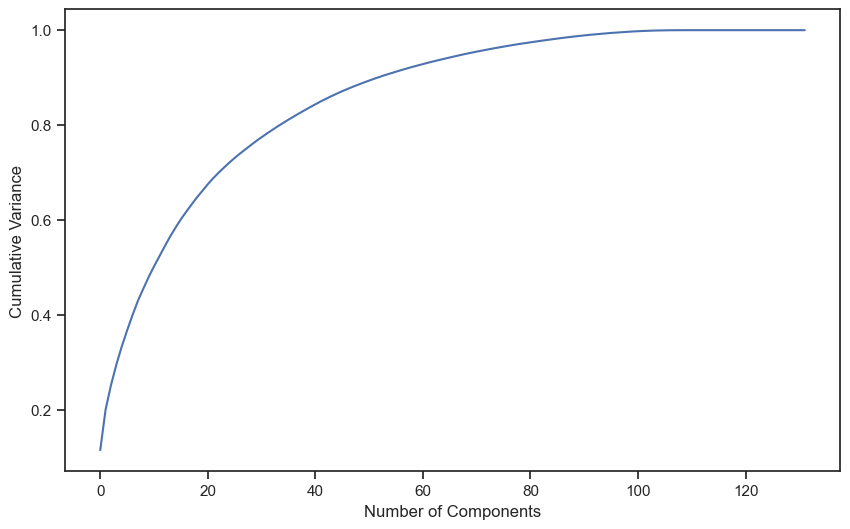

In [1189]:
# Plotting scree plot
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

We can see that `60 components` explain amost more than 90% variance of the data. So, we will perform PCA with 60 components.

##### Performing PCA with 60 components

In [1190]:
# Importing incremental PCA
from sklearn.decomposition import IncrementalPCA

In [1191]:
# Instantiate PCA with 60 components
pca_final = IncrementalPCA(n_components=60)

In [1192]:
# Fit and transform the X_train
X_train_pca = pca_final.fit_transform(X_train)

##### Applying transformation on the test set
We are only doing Transform in the test set not the Fit-Transform. Because the Fitting is already done on the train set. So, we just have to do the transformation with the already fitted data on the train set.

In [1193]:
X_test_pca = pca_final.transform(X_test)

#### Emphasize Sensitivity/Recall than Accuracy

We are more focused on higher Sensitivity/Recall score than the accuracy.

Beacuse we need to care more about churn cases than the not churn cases. The main goal is to reatin the customers, who have the possiblity to churn. There should not be a problem, if we consider few not churn customers as churn customers and provide them some incentives for retaining them. Hence, the sensitivity score is more important here.

## `Logistic regression with PCA`

In [1194]:
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression

In [1195]:
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#### Tuning hyperparameter  C
C is the the inverse of regularization strength in Logistic Regression. Higher values of C correspond to less regularization.

In [1196]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [1197]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [1198]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.163756,0.008072,0.021623,0.019694,0.01,{'C': 0.01},0.847349,0.846246,0.842882,0.851152,0.844369,0.846400,0.002829,6,0.847082,0.845896,0.848913,0.847892,0.846552,0.847267,0.001051
1,0.234676,0.016387,0.012359,0.000827,0.1,{'C': 0.1},0.847596,0.846246,0.843619,0.851636,0.846061,0.847032,0.002635,1,0.846840,0.846140,0.849460,0.847892,0.846431,0.847352,0.001210
2,0.210060,0.016677,0.012050,0.002933,1,{'C': 1},0.847102,0.846246,0.843619,0.851636,0.846061,0.846933,0.002622,2,0.846718,0.846201,0.849763,0.847953,0.846309,0.847389,0.001340
3,0.215712,0.015936,0.011685,0.000186,10,{'C': 10},0.847102,0.846006,0.843373,0.851636,0.846061,0.846836,0.002698,3,0.846718,0.845957,0.849703,0.847953,0.846248,0.847316,0.001375
4,0.212451,0.007540,0.011346,0.001591,100,{'C': 100},0.847102,0.845765,0.843373,0.851636,0.846061,0.846788,0.002714,4,0.846718,0.846018,0.849642,0.847953,0.846248,0.847316,0.001342
5,0.214794,0.016818,0.011255,0.001008,1000,{'C': 1000},0.847102,0.845765,0.843373,0.851636,0.846061,0.846788,0.002714,4,0.846718,0.846079,0.849642,0.847953,0.846248,0.847328,0.001330


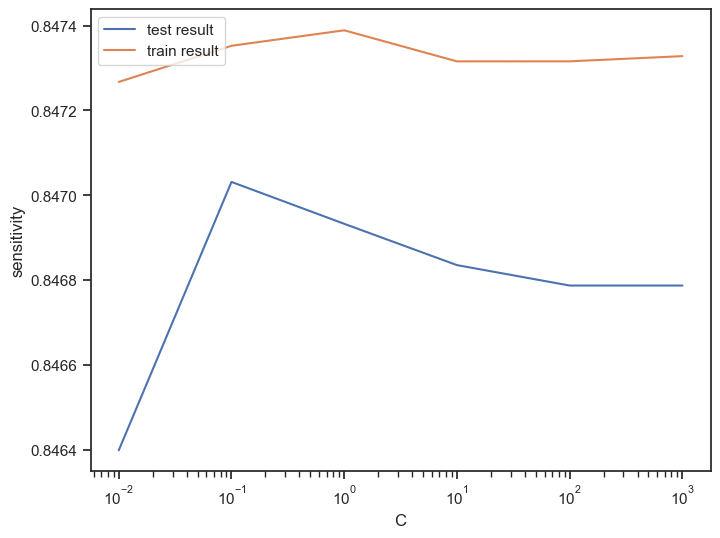

In [1199]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [1200]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.8470317179757026 at C = 0.1


#### Logistic regression with optimal C

In [1201]:
# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C)

In [1202]:
# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_train_pca, y_train)

##### Prediction on the train set

In [1203]:
# Predictions on the train set
y_train_pred = log_pca_model.predict(X_train_pca)

In [1204]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[16259  4282]
 [ 3127 17414]]


In [1205]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [1206]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8196533761744803
Sensitivity:- 0.8477678788763936
Specificity:- 0.791538873472567


##### Prediction on the test set

In [1207]:
# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_pca)

In [1208]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4067 1050]
 [ 114  338]]


In [1209]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [1210]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.790985814329323
Sensitivity:- 0.7477876106194691
Specificity:- 0.7948016415868673


***Model summary***

- Train set
    - Accuracy = 0.82
    - Sensitivity = 0.84
    - Specificity = 0.80
- Test set
    - Accuracy = 0.80
    - Sensitivity = 0.75
    - Specificity = 0.80
    
Overall, the model is performing well in the test set, what it had learnt from the train set.

## `Random forest with PCA`

In [1211]:
# Importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

##### Hyperparameter tuning

In [1213]:
param_grid = {
    'max_depth': [10,50],
    'min_samples_leaf': [100],
    'min_samples_split': [100],
    'n_estimators': [200], 
    'max_features': [20]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3,
                           verbose=1, 
                           return_train_score=True)

grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 50], 'max_features': [20],
                         'min_samples_leaf': [100], 'min_samples_split': [100],
                         'n_estimators': [200]},
             return_train_score=True, verbose=1)

In [1214]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8325544033883453 using {'max_depth': 50, 'max_features': 20, 'min_samples_leaf': 100, 'min_samples_split': 100, 'n_estimators': 200}


##### Model with optimal hyperparameters

In [1215]:
# model with the best hyperparameters

rfc_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             max_features=20,
                             n_estimators=300)

In [1216]:
# Fit the model
rfc_model.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=5, max_features=20, min_samples_leaf=50,
                       min_samples_split=100, n_estimators=300)

##### Prediction on the train set

In [1217]:
# Predictions on the train set
y_train_pred = rfc_model.predict(X_train_pca)

In [1218]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[16554  3987]
 [ 4188 16353]]


In [1219]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [1220]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8010077406163283
Sensitivity:- 0.7961150868993719
Specificity:- 0.8059003943332846


##### Prediction on the test set

In [1221]:
# Prediction on the test set
y_test_pred = rfc_model.predict(X_test_pca)

In [1222]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4148  969]
 [ 135  317]]


In [1223]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [1224]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8017597414257497
Sensitivity:- 0.7013274336283186
Specificity:- 0.8106312292358804


***Model summary***

- Train set
    - Accuracy = 0.80
    - Sensitivity = 0.80
    - Specificity = 0.80
- Test set
    - Accuracy = 0.80
    - Sensitivity = 0.70
    - Specificity = 0.81
    
    
We can see from the model performance that the Sesitivity has been decreased while evaluating the model on the test set. However, the accuracy and specificity is quite good in the test set.

### Final conclusion with PCA
After trying several models we can see that for acheiving the best sensitivity, which was our ultimate goal, the classic Logistic regression or the SVM models preforms well. For both the models the sensitivity was approx 75%. Also we have good accuracy of apporx 80%.

## Without PCA

## `Logistic regression with No PCA`

In [1225]:
##### Importing stats model
import statsmodels.api as sm

In [1226]:
# Instantiate the model
# Adding the constant to X_train
log_no_pca = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())

In [1227]:
# Fit the model
log_no_pca = log_no_pca.fit().summary()

In [1228]:
# Summary
log_no_pca

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             churn_flag   No. Observations:                41082
Model:                            GLM   Df Residuals:                    40950
Model Family:                Binomial   Df Model:                          131
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15161.
Date:                Tue, 06 Feb 2024   Deviance:                       30321.
Time:                        11:31:38   Pearson chi2:                 2.15e+06
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4770
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.7576      0.038     20.029      0.000       0.683       0.832
arpu_6                       0.5411      0.068      7.914      0.000       0.407       0.675
arpu_7                       0.4688      0.067      6.992      0.000       0.337       0.600
arpu_8                       0.6224      0.076      8.231      0.000       0.474       0.771
onnet_mou_6                  2.8017      2.167      1.293      0.196      -1.446       7.050
onnet_mou_7                  0.4062      1.519      0.267      0.789      -2.571       3.384
onnet_mou_8                 -3.6930      1.207     -3.061      0.002      -6.058      -1.328
offnet_mou_6                 3.5022      2.259      1.550      0.121      -0.926       7.930
offnet_mou_7                -0.1062      1.527     -0.070      0.945      -3.098       2.886
offnet_mou_8                -4.8389      1.221     -3.965      0.000      -7.231      -2.447
roam_ic_mou_6                0.0869      0.031      2.801      0.005       0.026       0.148
roam_ic_mou_7               -0.0544      0.034     -1.592      0.111      -0.121       0.013
roam_ic_mou_8               -0.0022      0.028     -0.078      0.938      -0.058       0.053
roam_og_mou_6               -0.9966      0.587     -1.699      0.089      -2.147       0.153
roam_og_mou_7                0.1912      0.381      0.502      0.616      -0.555       0.938
roam_og_mou_8                1.4615      0.395      3.703      0.000       0.688       2.235
loc_og_t2t_mou_6          1889.3259    570.993      3.309      0.001     770.201    3008.451
loc_og_t2t_mou_7          2771.8812    597.048      4.643      0.000    1601.688    3942.075
loc_og_t2t_mou_8          6766.7904    511.465     13.230      0.000    5764.337    7769.244
loc_og_t2m_mou_6          2079.6580    628.636      3.308      0.001     847.553    3311.763
loc_og_t2m_mou_7          2867.8804    617.714      4.643      0.000    1657.184    4078.577
loc_og_t2m_mou_8          7586.1539    573.349     13.231      0.000    6462.411    8709.897
loc_og_t2f_mou_6           159.5080     48.173      3.311      0.001      65.090     253.926
loc_og_t2f_mou_7           216.3516     46.654      4.637      0.000     124.912     307.791
loc_og_t2f_mou_8           608.5376     45.987     13.233      0.000     518.404     698.671
loc_og_t2c_mou_6            -0.0398      0.019     -2.069      0.039      -0.078      -0.002
loc_og_t2c_mou_7             0.0446      0.025      1.784      0.074      -0.004       0.094
loc_og_t2c_mou_8             0.0853      0.021      4.025      0.000       0.044       0.127
loc_og_mou_6             -3868.4623   1185.702     -3.263      0.001   -6192.395   -1544.529
loc_og_mou_7              -951.6492   1253.960     -0.759      0.448   -3409.367    1506.068
loc_og_mou_8  

***Model analysis***
1. We can see that there are few features have positive coefficients and few have negative.
2. Many features have higher p-values and hence became insignificant in the model.

***Coarse tuning (Auto+Manual)***

We'll first eliminate a few features using Recursive Feature Elimination (RFE), and once we have reached a small set of variables to work with, we can then use manual feature elimination (i.e. manually eliminating features based on observing the p-values and VIFs).

### Feature Selection Using RFE

In [1229]:
# Importing logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
# Intantiate the logistic regression
logreg = LogisticRegression()

#### RFE with 15 columns

In [1230]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Instantiate logistic regression model
logreg = LogisticRegression()

# Instantiate RFE with 15 columns
rfe = RFE(estimator=logreg, n_features_to_select=15)

# Fit the RFE model with the training set
rfe = rfe.fit(X_train, y_train)

In [1231]:
# RFE selected columns
rfe_cols = X_train.columns[rfe.support_]
print(rfe_cols)

Index(['arpu_6', 'onnet_mou_7', 'offnet_mou_8', 'loc_og_t2t_mou_8',
       'std_og_t2m_mou_7', 'std_og_mou_7', 'og_others_8', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'total_ic_mou_8', 'total_rech_num_8',
       'monthly_2g_8', 'monthly_3g_8', 'decrease_rech_num_action',
       'decrease_vbc_action'],
      dtype='object')


### Model-1 with RFE selected columns

In [1232]:
# Adding constant to X_train
X_train_sm_1 = sm.add_constant(X_train[rfe_cols])

# Instantiate the model
log_no_pca_1 = sm.GLM(y_train, X_train_sm_1, family=sm.families.Binomial())

# Fit the model
log_no_pca_1 = log_no_pca_1.fit()

log_no_pca_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             churn_flag   No. Observations:                41082
Model:                            GLM   Df Residuals:                    41066
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18711.
Date:                Tue, 06 Feb 2024   Deviance:                       37421.
Time:                        11:33:17   Pearson chi2:                 2.40e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3784
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1280      0.023      5.450      0.000       0.082       0.174
arpu_6                       0.3442      0.018     19.359      0.000       0.309       0.379
onnet_mou_7                  1.3808      0.077     17.964      0.000       1.230       1.531
offnet_mou_8                -0.7039      0.026    -26.939      0.000      -0.755      -0.653
loc_og_t2t_mou_8            -0.9098      0.047    -19.169      0.000      -1.003      -0.817
std_og_t2m_mou_7             1.7984      0.077     23.328      0.000       1.647       1.950
std_og_mou_7                -1.9638      0.106    -18.605      0.000      -2.171      -1.757
og_others_8                 -2.2133      0.690     -3.208      0.001      -3.566      -0.861
loc_ic_t2m_mou_7             0.6848      0.033     20.997      0.000       0.621       0.749
loc_ic_t2m_mou_8            -0.7271      0.060    -12.083      0.000      -0.845      -0.609
total_ic_mou_8              -1.2346      0.050    -24.486      0.000      -1.333      -1.136
total_rech_num_8            -0.6603      0.018    -36.140      0.000      -0.696      -0.624
monthly_2g_8                -0.6831      0.020    -34.272      0.000      -0.722      -0.644
monthly_3g_8                -0.7314      0.023    -32.374      0.000      -0.776      -0.687
decrease_rech_num_action    -0.7433      0.029    -25.268      0.000      -0.801      -0.686
decrease_vbc_action         -0.6983      0.042    -16.768      0.000      -0.780      -0.617
============================================================================================
"""

#### Checking VIFs

In [1233]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1234]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values, i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,std_og_mou_7,31.12
4,std_og_t2m_mou_7,16.62
1,onnet_mou_7,15.88
8,loc_ic_t2m_mou_8,4.86
7,loc_ic_t2m_mou_7,2.98
9,total_ic_mou_8,2.93
3,loc_og_t2t_mou_8,2.90
2,offnet_mou_8,1.81
0,arpu_6,1.35
10,total_rech_num_8,1.25


##### Removing column `std_og_mou_7`

In [1235]:
# Removing og_others_8 column 
log_cols = rfe_cols.to_list()
log_cols.remove('std_og_mou_7')
print(log_cols)

['arpu_6', 'onnet_mou_7', 'offnet_mou_8', 'loc_og_t2t_mou_8', 'std_og_t2m_mou_7', 'og_others_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'total_ic_mou_8', 'total_rech_num_8', 'monthly_2g_8', 'monthly_3g_8', 'decrease_rech_num_action', 'decrease_vbc_action']


### Model-2
Building the model after removing `std_og_mou_7` variable.

In [1236]:
# Adding constant to X_train
X_train_sm_2 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_2 = sm.GLM(y_train, X_train_sm_2, family=sm.families.Binomial())

# Fit the model
log_no_pca_2 = log_no_pca_2.fit()

log_no_pca_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             churn_flag   No. Observations:                41082
Model:                            GLM   Df Residuals:                    41067
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18905.
Date:                Tue, 06 Feb 2024   Deviance:                       37810.
Time:                        11:33:35   Pearson chi2:                 8.24e+06
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3725
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1410      0.024      5.994      0.000       0.095       0.187
arpu_6                       0.3901      0.018     22.275      0.000       0.356       0.424
onnet_mou_7                 -0.0161      0.015     -1.080      0.280      -0.045       0.013
offnet_mou_8                -0.7142      0.026    -27.570      0.000      -0.765      -0.663
loc_og_t2t_mou_8            -0.2490      0.026     -9.715      0.000      -0.299      -0.199
std_og_t2m_mou_7             0.4275      0.023     18.460      0.000       0.382       0.473
og_others_8                 -2.3145      0.742     -3.120      0.002      -3.769      -0.861
loc_ic_t2m_mou_7             0.7456      0.033     22.917      0.000       0.682       0.809
loc_ic_t2m_mou_8            -0.8085      0.060    -13.406      0.000      -0.927      -0.690
total_ic_mou_8              -1.2587      0.050    -25.043      0.000      -1.357      -1.160
total_rech_num_8            -0.6775      0.018    -37.210      0.000      -0.713      -0.642
monthly_2g_8                -0.6883      0.020    -34.560      0.000      -0.727      -0.649
monthly_3g_8                -0.7422      0.023    -32.821      0.000      -0.787      -0.698
decrease_rech_num_action    -0.7547      0.029    -25.824      0.000      -0.812      -0.697
decrease_vbc_action         -0.7150      0.042    -17.220      0.000      -0.796      -0.634
============================================================================================
"""

#### Checking VIF for Model-2

In [1237]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[log_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[log_cols].values, i) for i in range(X_train[log_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,loc_ic_t2m_mou_8,4.85
6,loc_ic_t2m_mou_7,2.98
8,total_ic_mou_8,2.93
2,offnet_mou_8,1.81
4,std_og_t2m_mou_7,1.56
0,arpu_6,1.33
1,onnet_mou_7,1.29
9,total_rech_num_8,1.25
3,loc_og_t2t_mou_8,1.20
12,decrease_rech_num_action,1.20


###  Model performance on the train set

In [1238]:
# Getting the predicted value on the train set
y_train_pred_no_pca = log_no_pca_2.predict(X_train_sm_2)
y_train_pred_no_pca.head()

0    0.395644
1    0.011528
2    0.504299
3    0.918938
4    0.500297
dtype: float64

##### Creating a dataframe with the actual churn and the predicted probabilities

In [1239]:
y_train_pred_final = pd.DataFrame({'churn_flag':y_train.values, 'churn_prob':y_train_pred_no_pca.values})

#Assigning Customer ID for each record for better readblity
#CustID is the index of each record.
y_train_pred_final['CustID'] = y_train_pred_final.index

y_train_pred_final.head()

,churn_flag,churn_prob,CustID
0,0,0.395644,0
1,0,0.011528,1
2,0,0.504299,2
3,0,0.918938,3
4,0,0.500297,4


##### Finding Optimal Probablity Cutoff Point

In [1240]:
# Creating columns for different probablity cutoffs
prob_cutoff = [float(p/10) for p in range(10)]

for i in prob_cutoff:
    y_train_pred_final[i] = y_train_pred_final['churn_prob'].map(lambda x : 1 if x > i else 0)
    
y_train_pred_final.head()

,churn_flag,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.395644,0,1,1,1,1,0,0,0,0,0,0
1,0,0.011528,1,1,0,0,0,0,0,0,0,0,0
2,0,0.504299,2,1,1,1,1,1,1,0,0,0,0
3,0,0.918938,3,1,1,1,1,1,1,1,1,1,1
4,0,0.500297,4,1,1,1,1,1,1,0,0,0,0


##### Now let's calculate the accuracy sensitivity and specificity for various probability cutoffs.

In [1241]:
# Creating a dataframe
cutoff_df = pd.DataFrame(columns=['probability', 'accuracy', 'sensitivity', 'specificity'])

for i in prob_cutoff:
    cm1 = metrics.confusion_matrix(y_train_pred_final['churn_flag'], y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)
    

     probability  accuracy  sensitivity  specificity
0.0          0.0  0.500000     1.000000     0.000000
0.1          0.1  0.653474     0.975123     0.331824
0.2          0.2  0.710360     0.953362     0.467358
0.3          0.3  0.749160     0.927073     0.571248
0.4          0.4  0.778711     0.894212     0.663210
0.5          0.5  0.795969     0.843971     0.747967
0.6          0.6  0.796967     0.767149     0.826785
0.7          0.7  0.772577     0.644029     0.901125
0.8          0.8  0.683900     0.411421     0.956380
0.9          0.9  0.549438     0.108320     0.990555


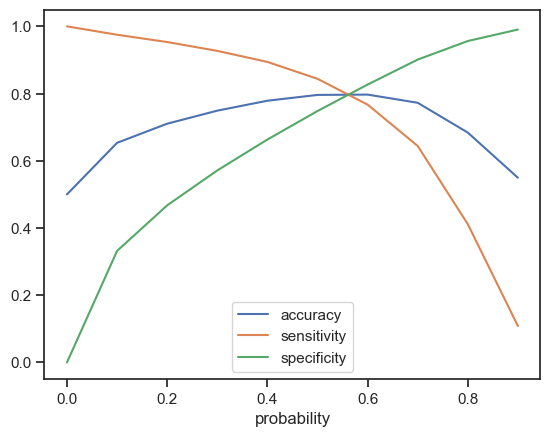

In [1242]:
# Plotting accuracy, sensitivity and specificity for different probabilities.
cutoff_df.plot('probability', ['accuracy','sensitivity','specificity'])
plt.show()

##### Analysis of the above curve
Accuracy - Becomes stable around 0.6

Sensitivity - Decreases with the increased probablity.

Specificity - Increases with the increasing probablity.

`At point 0.6` where the three parameters cut each other, we can see that there is a balance bethween sensitivity and specificity with a good accuracy.

Here we are intended to acheive better sensitivity than accuracy and specificity. Though as per the above curve, we should take 0.6 as the optimum probability cutoff, we are taking ***0.5*** for acheiving higher sensitivity, which is our main goal.

In [1243]:
# Creating a column with name "predicted", which is the predicted value for 0.5 cutoff 
y_train_pred_final['predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,churn_flag,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,predicted
0,0,0.395644,0,1,1,1,1,0,0,0,0,0,0,0
1,0,0.011528,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0.504299,2,1,1,1,1,1,1,0,0,0,0,1
3,0,0.918938,3,1,1,1,1,1,1,1,1,1,1,1
4,0,0.500297,4,1,1,1,1,1,1,0,0,0,0,1


##### Metrics

In [1244]:
# Confusion metrics
confusion = metrics.confusion_matrix(y_train_pred_final['churn_flag'], y_train_pred_final['predicted'])
print(confusion)

[[15364  5177]
 [ 3205 17336]]


In [1245]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [1246]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_pred_final['churn_flag'], y_train_pred_final['predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))


Accuracy:- 0.7959690375346867
Sensitivity:- 0.8439705953945768
Specificity:- 0.7479674796747967


We have got good accuracy, sensitivity and specificity on the train set prediction.

##### Plotting the ROC Curve (Trade off between sensitivity & specificity)

In [1247]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

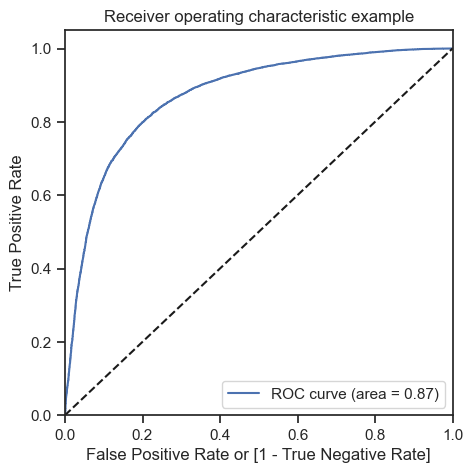

In [1248]:
draw_roc(y_train_pred_final['churn_flag'], y_train_pred_final['churn_prob'])

We can see the area of the ROC curve is closer to `0.9`, whic is the Gini of the model.

### Testing the model on the test set

In [1275]:
# Taking a copy of the test set
X_test_log = X_test.copy()

In [1276]:
# Taking only the columns, which are selected in the train set after removing insignificant and multicollinear variables
X_test_log = X_test_log[log_cols]

In [1277]:
# Adding constant on the test set
X_test_sm = sm.add_constant(X_test_log)

##### Predictions on the test set with final model

In [1278]:
# Predict on the test set
y_test_pred = log_no_pca_2.predict(X_test_sm)

In [1279]:
y_test_pred.head()

34843    0.819026
39113    0.242150
68881    0.434352
39087    0.413040
94831    0.072418
dtype: float64

In [1280]:
# Converting y_test_pred to a dataframe because y_test_pred is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
34843,0.819026
39113,0.242150
68881,0.434352
39087,0.413040
94831,0.072418


In [1281]:
# Convetting y_test to a dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn_flag
34843,0
39113,0
68881,0
39087,0
94831,0


In [1282]:
# Putting index to Customer ID 
y_test_df['CustID'] = y_test_df.index

In [1283]:
# Removing index form the both dataframes for merging them side by side
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [1284]:
# Appending y_pred_1 and y_test_df
y_test_pred_final = pd.concat([y_test_df, y_pred_1], axis=1)

In [1285]:
y_test_pred_final.head()

,churn_flag,CustID,0
0,0,34843,0.819026
1,0,39113,0.242150
2,0,68881,0.434352
3,0,39087,0.413040
4,0,94831,0.072418


In [1286]:
# Renaming the '0' column as churn probablity
y_test_pred_final = y_test_pred_final.rename(columns={0:'churn_prob'})

In [1287]:
# Rearranging the columns
y_test_pred_final = y_test_pred_final.reindex(['CustID','churn_flag','churn_prob'], axis=1)

In [1288]:
y_test_pred_final.head()

,CustID,churn_flag,churn_prob
0,34843,0,0.819026
1,39113,0,0.242150
2,68881,0,0.434352
3,39087,0,0.413040
4,94831,0,0.072418


In [1289]:
# In the test set using probablity cutoff 0.5, what we got in the train set 
y_test_pred_final['test_predicted'] = y_test_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

In [1290]:
y_test_pred_final.head()

,CustID,churn_flag,churn_prob,test_predicted
0,34843,0,0.819026,1
1,39113,0,0.242150,0
2,68881,0,0.434352,0
3,39087,0,0.413040,0
4,94831,0,0.072418,0


In [1292]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test_pred_final['churn_flag'], y_test_pred_final['test_predicted'])
print(confusion)

[[3824 1293]
 [ 108  344]]


In [1293]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [1295]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test_pred_final['churn_flag'], y_test_pred_final['test_predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))


Accuracy:- 0.7484288022984378
Sensitivity:- 0.7610619469026548
Specificity:- 0.747312878639828


***Model summary***

- Train set
    - Accuracy = 0.80
    - Sensitivity = 0.85
    - Specificity = 0.75
- Test set
    - Accuracy = 0.75
    - Sensitivity = 0.77
    - Specificity = 0.75
    
Overall, the model is performing well in the test set, what it had learnt from the train set.

#### Final conclusion with no PCA

We can see that the logistic model with no PCA has good sensitivity and accuracy, which are comparable to the models with PCA. So, we can go for the more simplistic model such as logistic regression with PCA as it expliains the important predictor variables as well as the significance of each variable. The model also hels us to identify the variables which should be act upon for making the decision of the to be churned customers. Hence, the model is more relevant in terms of explaining to the business.

## Business recomendation

#### Top predictors

Below are few top variables selected in the logistic regression model.



| Variables   | Coefficients |
|---------------------|--------------|
|og_others_8 | -2.3145
total_ic_mou_8 | -1.2587
loc_ic_t2m_mou_8 | -0.8085
decrease_rech_num_action | -0.7547
monthly_3g_8 | -0.7422
decrease_vbc_action | -0.715
offnet_mou_8 | -0.7142
monthly_2g_8 | -0.6883
total_rech_num_8 | -0.6775
loc_og_t2t_mou_8 | -0.249
onnet_mou_7 | -0.0161
arpu_6 | 0.3901
std_og_t2m_mou_7 | 0.4275
loc_ic_t2m_mou_7 | 0.7456


We can see most of the top variables have negative coefficients. That means, the variables are inversely correlated with the churn probablity.

E.g.:- 

If the outgoing minutes of usage `(og_others_8)` is lesser in the month of August than any other month, then there is a higher chance that the customer is likely to churn.

***Recomendations***

1. Target the customers, whose minutes of usage of the `outgoing calls` and the `total incoming calls` are less in the action phase (mostly in the month of August).
2. Cutomers, whose `monthly 3G recharge in August` is more, are likely to be churned. 
3. Customers having `decreasing STD incoming minutes of usage for operators T to fixed lines of T` for the month of August are more likely to churn.
4. Cutomers `decreasing monthly 2g` usage for August are most probable to churn.
5. Customers having decreasing incoming minutes of usage for operators T to fixed lines of T for August are more likely to churn.

#### Plots of important predictors for churn and non churn customers

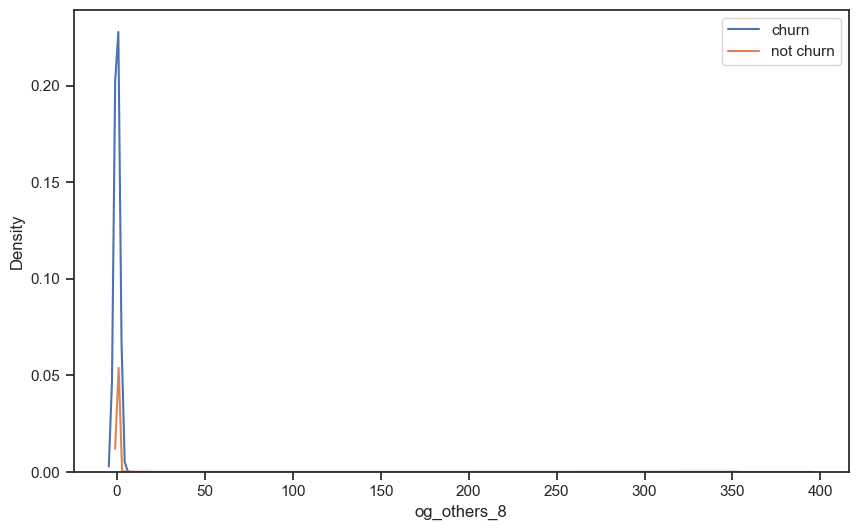

In [1298]:
# Plotting loc_ic_mou_8 predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['og_others_8'],label='churn',hist=False)
sns.distplot(data_non_churn['og_others_8'],label='not churn',hist=False)
plt.legend()
plt.show()

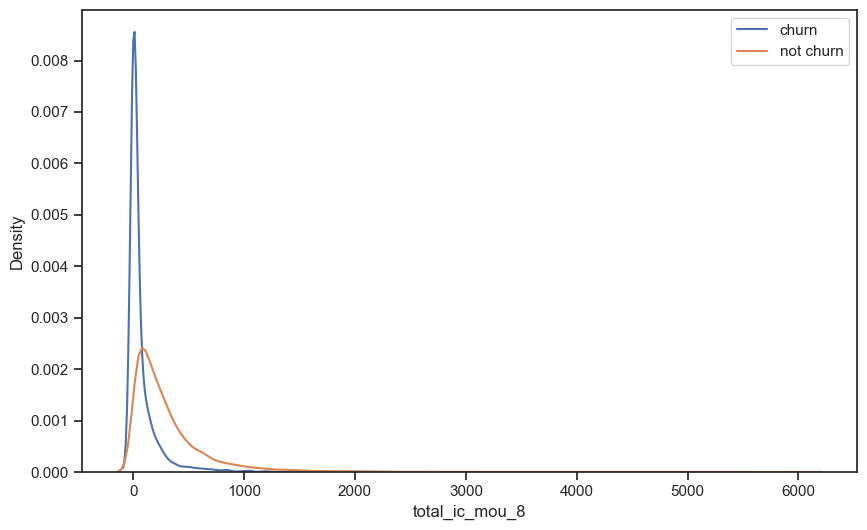

In [1299]:
# Plotting isd_og_mou_8 predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['total_ic_mou_8'],label='churn',hist=False)
sns.distplot(data_non_churn['total_ic_mou_8'],label='not churn',hist=False)
plt.legend()
plt.show()